<a href="https://colab.research.google.com/github/Bovi-analytics/hut-et-al-2021/blob/master/LyingTime_24h_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical notebook for lying time

## Importing of google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## R loading

In [ ]:
%reload_ext rpy2.ipython

In [ ]:
%%R
lib_loc <- "/content/drive/Shareddrives/Bovi-Analytics/R-lib/"

In [ ]:
%%R
package_list <- c("ggplot2",
                  "readr",
                  "plyr",
                  "dplyr",
                  "tidyr",                
                  "lme4",
                  "lmerTest",
                  "multcompView",
                  "mvtnorm",
                  "TH.data",
                  "multcomp",
                  "emmeans",
                  "lsmeans",
                  "carData",
                  "car"
                  )

for (pkg in package_list) {
  if (pkg %in% rownames(.packages()) == FALSE)
  {library(pkg, lib.loc = lib_loc, character.only = TRUE)}

}

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step


R[write to console]: Loading required package: survival

R[write to console]: Loading required package: MASS

R[write to console]: 
Attaching

In [ ]:
%%R
options(warn=-1)

## Data loading into dataframe

In [ ]:
%%R

#path <- "/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/ObservationType=LyingTimeMinutesPer2Hours/part-00000-tid-183333261268000902-29b42dfd-564e-4e7d-8ea7-05b4fb30d5d6-1694-25.c000.csv"
AnalysisData <- 
  readr::read_csv("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/ObservationType=LyingTimeMinutesPer2Hours/part-00000-tid-183333261268000902-29b42dfd-564e-4e7d-8ea7-05b4fb30d5d6-1694-25.c000.csv", 
    col_types = readr::cols(HerdIdentifier = readr::col_character(), 
        TransitionLactationNumber = readr::col_integer(), 
        TransitionParity = readr::col_character(), 
        TransitionMonthsInMilk = readr::col_integer(), 
        TransitionCalvingDate = readr::col_character(), 
        Hour = readr::col_integer(), 
        Observations = readr::col_integer())) %>% 
  dplyr::filter(dplyr::between(TransitionMonthsInMilk, 1, 10)) %>%
  dplyr::mutate(
    AnimalIdentifier = factor(AnimalIdentifier),
    HerdIdentifier = factor(HerdIdentifier),
    Parity = factor(TransitionParity),
    MonthsInMilk = factor(TransitionMonthsInMilk),
    CalvingSeason = factor(TransitionSeason),
    Hour = factor(Hour),
    SensorValue = ObservationValue,
    MilkingType = factor(case_when(
    HerdIdentifier %in% c("544", "2514", "3314")~"AMS",
    TRUE~"CMS"
  ))
  ) %>%
  dplyr::select(AnimalIdentifier, HerdIdentifier, Parity, MonthsInMilk, CalvingSeason, Hour, SensorValue, MilkingType) %>%
  tidyr::drop_na()

In [ ]:
%%R
head(AnalysisData)

# A tibble: 6 x 8
  AnimalIdentifier HerdIdentifier Parity MonthsInMilk CalvingSeason Hour 
  <fct>            <fct>          <fct>  <fct>        <fct>         <fct>
1 8312             2011           3+     3            Autumn        16   
2 1304             5888           3+     1            Summer        10   
3 8312             2011           3+     5            Summer        16   
4 1304             5888           3+     6            Summer        10   
5 1304             5888           1      5            Summer        12   
6 1304             5888           3+     3            Summer        18   
# … with 2 more variables: SensorValue <dbl>, MilkingType <fct>


In [ ]:
%%R
str(AnalysisData)

tibble[,8] [426,442 × 8] (S3: tbl_df/tbl/data.frame)
 $ AnimalIdentifier: Factor w/ 1041 levels "1","2","3","4",..: 732 500 732 500 500 500 473 1016 118 118 ...
 $ HerdIdentifier  : Factor w/ 8 levels "2011","2297",..: 1 8 1 8 8 8 8 1 7 7 ...
 $ Parity          : Factor w/ 3 levels "1","2","3+": 3 3 3 3 1 3 2 1 3 3 ...
 $ MonthsInMilk    : Factor w/ 10 levels "1","2","3","4",..: 3 1 5 6 5 3 6 2 2 7 ...
 $ CalvingSeason   : Factor w/ 4 levels "Autumn","Spring",..: 1 3 3 3 3 3 3 2 4 2 ...
 $ Hour            : Factor w/ 12 levels "0","2","4","6",..: 9 6 9 6 7 10 6 7 1 2 ...
 $ SensorValue     : num [1:426442] 55.07 36.13 41.95 6.53 54.27 ...
 $ MilkingType     : Factor w/ 2 levels "AMS","CMS": 2 2 2 2 2 2 2 2 1 1 ...


## Descriptive statistics

In [ ]:
%%R
AnalysisData %>% group_by("Parity") %>% n_distinct()

[1] 426398


In [ ]:
%%R
AnalysisData %>%
  group_by(Parity) %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 3 x 2
  Parity Unique_Elements
  <fct>            <int>
1 1                  689
2 2                  682
3 3+                 723


In [ ]:
%%R
AnalysisData %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 1 x 1
  Unique_Elements
            <int>
1            1041


# Model building

First we determine the null model

## Null model

In [ ]:
%%R
Model.0 <- lme4::lmer(
                  SensorValue ~ 1 + (1| HerdIdentifier:AnimalIdentifier), 
                  data = AnalysisData
                  )

## Univariable models

In [ ]:
%%R
Model1.0 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model.0,Model1.0,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.0: SensorValue ~ MonthsInMilk + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 3819303 3819335 -1909648  3819297                         
Model1.0   12 3814016 3814147 -1906996  3813992 5304.6  9  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.1 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.1,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.1: SensorValue ~ Parity + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 3819303 3819335 -1909648  3819297                         
Model1.1    5 3818888 3818943 -1909439  3818878 418.05  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.2 <- lme4::lmer(
                  SensorValue ~ 
                  HerdIdentifier + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.2,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.2: SensorValue ~ HerdIdentifier + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 3819303 3819335 -1909648  3819297                         
Model1.2   10 3819073 3819183 -1909527  3819053 243.35  7  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.3 <- lme4::lmer(
                  SensorValue ~ 
                  CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.3,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.3: SensorValue ~ CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 3819303 3819335 -1909648  3819297                         
Model1.3    6 3819137 3819202 -1909562  3819125 171.92  3  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.4 <- lme4::lmer(
                  SensorValue ~ 
                  Hour +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.4,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.4: SensorValue ~ Hour + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 3819303 3819335 -1909648  3819297                         
Model1.4   14 3683776 3683929 -1841874  3683748 135549 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.5 <- lme4::lmer(
                  SensorValue ~ 
                  MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.5,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.5: SensorValue ~ MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance Chisq Df Pr(>Chisq)    
Model.0     3 3819303 3819335 -1909648  3819297                        
Model1.5    4 3819181 3819225 -1909586  3819173 123.7  1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multivariable models

In [ ]:
%%R
Model2.0 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + MonthsInMilk + CalvingSeason + Hour + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )

In [ ]:
%%R
drop1(Model2.0,test="Chisq")

Single term deletions

Model:
SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
    MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
              npar     AIC    LRT   Pr(Chi)    
<none>             3675661                     
Parity           2 3675974    316 < 2.2e-16 ***
MonthsInMilk     9 3682815   7172 < 2.2e-16 ***
CalvingSeason    3 3676087    432 < 2.2e-16 ***
Hour            11 3813389 137749 < 2.2e-16 ***
MilkingType      1 3675768    109 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Introduction of interactions

### Interactions with MonthsInMilk

In [ ]:
%%R
Model2.1 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*Parity + Hour + HerdIdentifier + CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.1,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.1: SensorValue ~ MonthsInMilk * Parity + Hour + HerdIdentifier + 
Model2.1:     CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3675661 3675979 -1837802  3675603                         
Model2.1   53 3674774 3675356 -1837334  3674668 934.86 24  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.2 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*MilkingType + Parity + Hour + CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.2,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.2: SensorValue ~ MonthsInMilk * MilkingType + Parity + Hour + CalvingSeason + 
Model2.2:     (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3675661 3675979 -1837802  3675603                         
Model2.2   38 3675565 3675981 -1837744  3675489 114.84  9  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.3 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + Parity + Hour + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.3,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.3: SensorValue ~ MonthsInMilk * CalvingSeason + Parity + Hour + 
Model2.3:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3675661 3675979 -1837802  3675603                         
Model2.3   56 3673328 3673942 -1836608  3673216 2387.7 27  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Interactions with hour

In [ ]:
%%R
Model2.4 <- lme4::lmer(
                  SensorValue ~ 
                  Hour*Parity + MonthsInMilk + CalvingSeason + MilkingType + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.4,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.4: SensorValue ~ Hour * Parity + MonthsInMilk + CalvingSeason + 
Model2.4:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3675661 3675979 -1837802  3675603                         
Model2.4   51 3673411 3673970 -1836654  3673309 2294.7 22  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.5 <- lme4::lmer(
                  SensorValue ~ 
                  Hour*MilkingType + MonthsInMilk + CalvingSeason + Parity + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.5,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.5: SensorValue ~ Hour * MilkingType + MonthsInMilk + CalvingSeason + 
Model2.5:     Parity + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance Chisq Df Pr(>Chisq)    
Model2.0   29 3675661 3675979 -1837802  3675603                        
Model2.5   40 3652139 3652578 -1826030  3652059 23544 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.6 <- lme4::lmer(
                  SensorValue ~ 
                  Hour*CalvingSeason + MonthsInMilk +  + Parity + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.6,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.6: SensorValue ~ Hour * CalvingSeason + MonthsInMilk + +Parity + 
Model2.6:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3675661 3675979 -1837802  3675603                         
Model2.6   62 3674742 3675422 -1837309  3674618 985.51 33  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multiple interactions

In [ ]:
%%R
Model2.7 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*Parity + 
                  MonthsInMilk*MilkingType + 
                  MonthsInMilk*CalvingSeason + 
                  Hour*Parity + 
                  Hour*MilkingType + 
                  Hour*CalvingSeason + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.7,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.7: SensorValue ~ MonthsInMilk * Parity + MonthsInMilk * MilkingType + 
Model2.7:     MonthsInMilk * CalvingSeason + Hour * Parity + Hour * MilkingType + 
Model2.7:     Hour * CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance Chisq  Df Pr(>Chisq)    
Model2.0   29 3675661 3675979 -1837802  3675603                         
Model2.7  149 3645972 3647605 -1822837  3645674 29930 120  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Final model analysis of variance

In [ ]:
%%R
finalModel <- Model2.7

In [ ]:
%%R
Anova(finalModel)

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: SensorValue
                                Chisq Df Pr(>Chisq)    
MonthsInMilk                 7759.187  9  < 2.2e-16 ***
Parity                        280.500  2  < 2.2e-16 ***
MilkingType                   101.578  1  < 2.2e-16 ***
CalvingSeason                 459.167  3  < 2.2e-16 ***
Hour                       174595.639 11  < 2.2e-16 ***
MonthsInMilk:Parity           888.488 18  < 2.2e-16 ***
MonthsInMilk:MilkingType       75.574  9  1.217e-12 ***
MonthsInMilk:CalvingSeason   2601.568 27  < 2.2e-16 ***
Parity:Hour                  2252.364 22  < 2.2e-16 ***
MilkingType:Hour            23976.217 11  < 2.2e-16 ***
CalvingSeason:Hour            601.026 33  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
save(finalModel, file="/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/finalmodel2hourslyingtime.rdata")

# Final model figures and LSM (95% CI)

## Main effects

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MonthsInMilk), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 426442' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 426442)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 426442' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 426442)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL .group   
 1              52.4 0.211 Inf      51.8      53.0  a       
 2              53.4 0.211 Inf      52.9      54.0   b      
 3              54.8 0.210 Inf      54.2      55.3    c     
 4              56.2 0.210 Inf      55.6      56.8     d    
 5              57.6 0.210 Inf      57.0      58.2      e   
 6              58.2 0.210 Inf      57.6      58.8       f  
 7              58.7 0.210 Inf      58.1      59.2        g 
 8              58.9 0.209 Inf      58.3      59.5        g 
 9              59.0 0.210 Inf      58.5      59.6        gh
 10             59.4 0.210 Inf      58.8      60.0         h

Results are averaged over the levels of: Parity, MilkingType, CalvingSeason, Hour 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 10 estimates 
P value adjustment: tukey method for comparing a family of 10 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ Parity), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 426442' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 426442)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 426442' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 426442)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 Parity lsmean    SE  df asymp.LCL asymp.UCL .group
 3+       56.0 0.194 Inf      55.6      56.5  a    
 2        57.2 0.196 Inf      56.7      57.7   b   
 1        57.4 0.197 Inf      56.9      57.8   b   

Results are averaged over the levels of: MonthsInMilk, MilkingType, CalvingSeason, Hour 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 3 estimates 
P value adjustment: tukey method for comparing a family of 3 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ Hour), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 426442' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 426442)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 426442' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 426442)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 Hour lsmean    SE  df asymp.LCL asymp.UCL .group      
 16     35.8 0.214 Inf      35.2      36.4  a          
 18     46.2 0.214 Inf      45.6      46.8   b         
 14     46.4 0.214 Inf      45.8      47.0   b         
 6      52.6 0.214 Inf      52.0      53.2    c        
 12     53.9 0.214 Inf      53.3      54.5     d       
 8      54.5 0.214 Inf      53.9      55.1      e      
 10     56.9 0.214 Inf      56.3      57.6       f     
 20     60.5 0.214 Inf      59.8      61.1        g    
 4      61.5 0.214 Inf      60.9      62.1         h   
 22     66.7 0.214 Inf      66.0      67.3          i  
 0      70.6 0.214 Inf      70.0      71.3           j 
 2      76.8 0.214 Inf      76.1      77.4            k

Results are averaged over the levels of: MonthsInMilk, Parity, MilkingType, CalvingSeason 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 12 estimates 
P value adjustment: tukey method for comparing a family of

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ CalvingSeason), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 426442' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 426442)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 426442' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 426442)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 CalvingSeason lsmean    SE  df asymp.LCL asymp.UCL .group
 Winter          55.6 0.205 Inf      55.1      56.1  a    
 Spring          56.3 0.205 Inf      55.8      56.8   b   
 Autumn          57.4 0.201 Inf      56.9      57.9    c  
 Summer          58.2 0.201 Inf      57.7      58.7     d 

Results are averaged over the levels of: MonthsInMilk, Parity, MilkingType, Hour 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 4 estimates 
P value adjustment: tukey method for comparing a family of 4 estimates 
significance level used: alpha = 0.05 


## Interactions

### Hour by parity

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ Hour|Parity, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 426442' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 426442)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 426442' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 426442)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



Parity = 1:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group     
 16     36.1 0.267 Inf      35.3      36.9  a         
 18     46.3 0.267 Inf      45.5      47.1   b        
 14     46.5 0.267 Inf      45.7      47.2   b        
 6      51.9 0.267 Inf      51.2      52.7    c       
 8      53.4 0.267 Inf      52.6      54.1     d      
 12     53.9 0.267 Inf      53.1      54.7     d      
 10     56.6 0.267 Inf      55.9      57.4      e     
 20     60.5 0.267 Inf      59.8      61.3       f    
 4      61.7 0.267 Inf      60.9      62.4        g   
 22     68.4 0.267 Inf      67.6      69.2         h  
 0      73.3 0.267 Inf      72.5      74.0          i 
 2      79.8 0.267 Inf      79.0      80.6           j

Parity = 2:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group     
 16     36.2 0.264 Inf      35.4      36.9  a         
 14     46.0 0.264 Inf      45.3      46.8   b        
 18     46.0 0.264 Inf      45.3      46.8   b        
 6      53.1 0.264 Inf      52.4      53

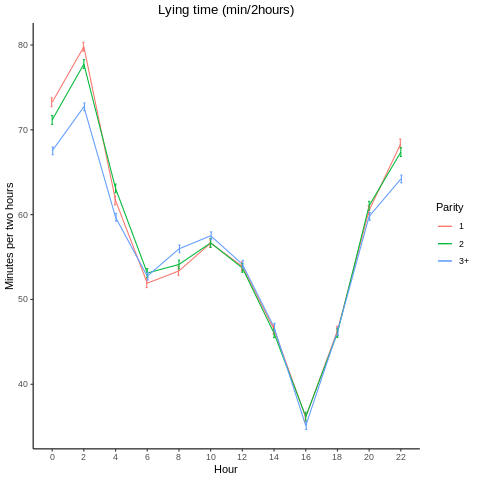

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(Hour == max(as.numeric(Hour)), as.character(Parity), NA_character_)) %>%
  ggplot(
  aes(
    x=Hour,
    y=lsmean,
    group=Parity, 
    color=Parity)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Lying time (min/2hours)", 
    y="Minutes per two hours" , 
    x = "Hour") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

### Hour by milking type

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ Hour|MilkingType, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 426442' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 426442)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 426442' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 426442)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



MilkingType = AMS:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group      
 18     42.8 0.354 Inf      41.8      43.8  a          
 16     42.8 0.354 Inf      41.8      43.8  a          
 14     50.7 0.354 Inf      49.7      51.7   b         
 8      51.8 0.354 Inf      50.8      52.9    c        
 12     55.6 0.354 Inf      54.5      56.6     d       
 20     57.4 0.354 Inf      56.4      58.4      e      
 6      57.9 0.354 Inf      56.9      59.0      ef     
 10     58.4 0.354 Inf      57.3      59.4       f     
 22     66.1 0.354 Inf      65.1      67.1        g    
 0      70.0 0.354 Inf      69.0      71.0         h   
 4      73.7 0.354 Inf      72.6      74.7          i  
 2      78.0 0.354 Inf      77.0      79.0           j 

MilkingType = CMS:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group      
 16     28.8 0.237 Inf      28.1      29.5  a          
 14     42.1 0.237 Inf      41.4      42.7   b         
 6      47.2 0.237 Inf      46.6      47.9    c        
 4      4

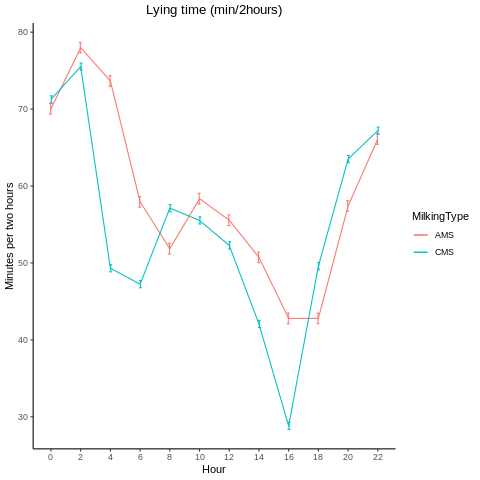

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(Hour == max(as.numeric(Hour)), as.character(MilkingType), NA_character_)) %>%
  ggplot(
  aes(
    x=Hour,
    y=lsmean,
    group=MilkingType, 
    color=MilkingType)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Lying time (min/2hours)", 
    y="Minutes per two hours" , 
    x = "Hour") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

### Hour by calving season

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ Hour|CalvingSeason, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 426442' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 426442)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 426442' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 426442)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



CalvingSeason = Autumn:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group      
 16     36.3 0.266 Inf      35.5      37.0  a          
 18     46.4 0.266 Inf      45.6      47.2   b         
 14     48.6 0.266 Inf      47.9      49.4    c        
 6      52.9 0.266 Inf      52.1      53.6     d       
 12     54.7 0.266 Inf      53.9      55.4      e      
 8      54.7 0.266 Inf      53.9      55.5      e      
 10     56.5 0.266 Inf      55.7      57.2       f     
 20     60.9 0.266 Inf      60.2      61.7        g    
 4      62.9 0.266 Inf      62.1      63.6         h   
 22     67.1 0.266 Inf      66.3      67.9          i  
 0      71.0 0.266 Inf      70.3      71.8           j 
 2      77.3 0.266 Inf      76.5      78.0            k

CalvingSeason = Spring:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group      
 16     36.3 0.282 Inf      35.5      37.1  a          
 14     44.6 0.282 Inf      43.8      45.4   b         
 18     45.7 0.282 Inf      44.9      46.5    c        

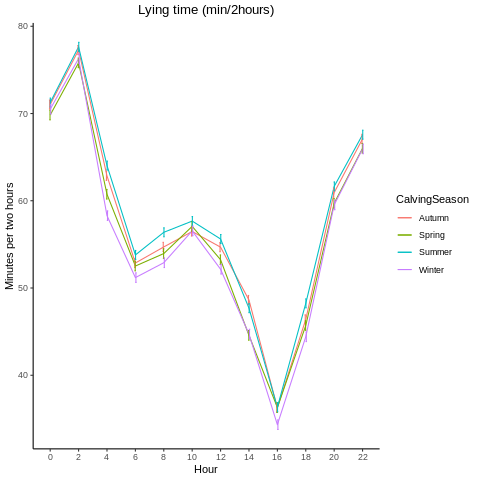

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(Hour == max(as.numeric(Hour)), as.character(CalvingSeason), NA_character_)) %>%
  ggplot(
  aes(
    x=Hour,
    y=lsmean,
    group=CalvingSeason, 
    color=CalvingSeason)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Lying time (min/2hours)", 
    y="Minutes per two hours" , 
    x = "Hour") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))